In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import warnings;warnings.filterwarnings('ignore')

import pandas as pd
import re
import math
import numpy as np
from lightgbm import LGBMRegressor
import time

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from rapidfuzz import process, fuzz

In [2]:
# address = pd.read_csv('./data/address.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
bus_feature = pd.read_csv('./data/bus_feature.csv')
subway_feature = pd.read_csv('./data/subway_feature.csv')
address = pd.read_csv('./data/addresses.csv')

In [3]:
train = train.rename(columns={
    "좌표X": "X",
    "좌표Y": "Y"
})

test = test.rename(columns={
    "좌표X": "X",
    "좌표Y": "Y"
})

bus_feature = bus_feature.rename(columns={
    "X좌표": "X",
    "Y좌표": "Y"
})

subway_feature = subway_feature.rename(columns={
    "경도": "X",
    "위도": "Y"
})

In [4]:
import re
import pandas as pd

def split_sigungu(addr):
    m1, m2 = None, None
    if not addr:
        return m1, m2

    # '구'로 끝나는 부분 찾기
    m = re.search(r'([가-힣]+구)', addr)
    if m:
        m1 = m.group(1)
        # 구 이후 남은 문자열 전체 추출 (앞뒤 공백 제거)
        m2 = addr[m.end():].strip() if m.end() < len(addr) else None

    return m1, m2

# 적용 예시
train[['구','동']] = train['시군구'].apply(lambda x: pd.Series(split_sigungu(x)))
test[['구','동']] = test['시군구'].apply(lambda x: pd.Series(split_sigungu(x)))


In [5]:
train.isna().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [6]:
train['address'] = train['시군구'] + ' ' + train['도로명']
test['address'] = test['시군구'] + ' ' + test['도로명']

In [7]:
train['address']

0               서울특별시 강남구 개포동 언주로 3
1               서울특별시 강남구 개포동 언주로 3
2               서울특별시 강남구 개포동 언주로 3
3               서울특별시 강남구 개포동 언주로 3
4               서울특별시 강남구 개포동 언주로 3
                     ...           
1118817    서울특별시 은평구 구산동 서오릉로21길 36
1118818    서울특별시 은평구 구산동 서오릉로21길 36
1118819    서울특별시 은평구 구산동 서오릉로21길 36
1118820    서울특별시 은평구 구산동 서오릉로21길 36
1118821       서울특별시 중구 묵정동 서애로1길 34
Name: address, Length: 1118822, dtype: object

## 결측치 처리

### train data

In [8]:
train.isna().sum()[train.isna().sum() > 0]

번지                            225
본번                             75
부번                             75
아파트명                         2126
해제사유발생일                   1112839
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적                   869608
k-관리비부과면적                  869563
k-전용면적별세대현황(60㎡이하)         869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-135㎡초과                  1118495
k-홈페이지                    1005647
k-등록일자                    1107832
k-수정일자                     869608
고용보험관리번호                   913304
경비비관리형태       

### X,Y 결측치

In [9]:
train_df = train.drop(columns=['X','Y'])

In [10]:
train_df

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,address
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,124000,강남구,개포동,서울특별시 강남구 개포동 언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,123500,강남구,개포동,서울특별시 강남구 개포동 언주로 3
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,91500,강남구,개포동,서울특별시 강남구 개포동 언주로 3
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,130000,강남구,개포동,서울특별시 강남구 개포동 언주로 3
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,117000,강남구,개포동,서울특별시 강남구 개포동 언주로 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,366.0,의무,2013-06-04 16:18:51.0,Y,N,2013-03-07 09:46:27.0,20000,은평구,구산동,서울특별시 은평구 구산동 서오릉로21길 36
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,366.0,의무,2013-06-04 16:18:51.0,Y,N,2013-03-07 09:46:27.0,20000,은평구,구산동,서울특별시 은평구 구산동 서오릉로21길 36
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,366.0,의무,2013-06-04 16:18:51.0,Y,N,2013-03-07 09:46:27.0,28000,은평구,구산동,서울특별시 은평구 구산동 서오릉로21길 36
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,366.0,의무,2013-06-04 16:18:51.0,Y,N,2013-03-07 09:46:27.0,29000,은평구,구산동,서울특별시 은평구 구산동 서오릉로21길 36


In [11]:
addr_dict = address.set_index('address')[['X', 'Y']].to_dict('index')

In [12]:
def addr_feature(d, a):
    a = a.strip()
    if a in d:
        return d[a]['X'], d[a]['Y']
    else:
        return float('nan'), float('nan')

In [13]:
train_df[['X','Y']] = train_df['address'].apply(lambda x: pd.Series(addr_feature(addr_dict, x)))

In [14]:
train_df.isna().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [15]:
ct_companies = list(set(train_df['k-건설사(시공사)']))
apt_names = list(set(train_df['아파트명']))

In [16]:
len(apt_names)

6539

In [17]:
len(ct_companies)

345

### 난방방식

In [18]:
train_df['k-난방방식'].isna().sum()

869563

In [19]:
list(set(train['아파트명']))

['e편한세상신촌2단지',
 '길음뉴타운1단지',
 '청담파라곤Ⅱ1단지',
 '은행',
 '한신주택',
 '한림리첸빌101동',
 '상계불암대림',
 '청광플러스원',
 '신반포22',
 '가우디캐슬',
 '덕동반포빌라트',
 '하이존',
 '방배힐2차',
 '효민아크로뷰',
 '크래스빌',
 '목동신시가지11',
 '캠퍼스프라자',
 '대상',
 '당산삼성2차',
 '한일노벨리아',
 '현대2',
 '대우',
 '수락한신',
 '광정',
 '타운빌라트',
 '한성',
 '송파더센트레',
 '자양동삼성',
 '신림2차현대',
 '신림2차푸르지오',
 '하늘바람',
 '대우리츠카운티',
 '반석블레스빌',
 '선영베스트',
 '방배중앙센트레빌',
 '801-9',
 '둔촌주공4단지',
 '드림팰리스',
 '동양드림',
 '라르파크',
 '한보1',
 '한울앤하우스',
 '송광',
 '래미안방배에버뉴',
 '중계3우성',
 '프라비다트라움',
 '남산FORESTHOUSE',
 '설록',
 '우리스페이스',
 '마포용강삼성래미안',
 '월계역신도브래뉴',
 '쎈트앤빌',
 '신동아리버파크',
 '동원데쟈뷰',
 '래미안강동팰리스',
 '진로,미주',
 '상림마을7단지아이파크BL1-14',
 '미도',
 '베스트빌',
 '늘푸른3차',
 '노아아크빌',
 '현대맨션',
 '우진',
 '엘에이치송파도시형생활주택',
 '참다움',
 '우남푸르미아',
 '북한산대창센시티',
 '창동그린',
 '힐스테이트송파위례',
 '역삼동월드메르디앙',
 '한신그린',
 'U포그니2차',
 '목동신시가지4',
 '에스아이팰리스송파올림픽공원',
 '신동아',
 '아델스빌1',
 '꿈의숲SKVIEW',
 '천왕이펜하우스6단지',
 '동답한신',
 '삼성파크타워',
 '2차한양',
 '두영이지안102동',
 '목동신시가지10',
 'FIRSTVIEW',
 '삼성빌라트',
 '역삼우정에쉐르2',
 '벽산솔렌스힐',
 '에스엠케이',
 '송림주택',
 '유로카운티',
 '창동2차현대',
 '로얄

In [20]:
set(train_df['k-난방방식'])

{nan, '개별난방', '기타', '중앙난방', '지역난방'}

In [21]:
set(train_df['건축년도'])

{1961,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023}

In [22]:
train_df[train_df['k-난방방식'].isna()&(train_df['건축년도'] < 2005)]['k-난방방식'] = '중앙난방'
test[test['k-난방방식'].isna()&(test['건축년도'] < 2005)]['k-난방방식'] = '중앙난방'


In [23]:
train_df['k-난방방식'].isna().sum()

869563

In [24]:
import pandas as pd
import numpy as np
import random

# 구별 난방 정보 (키: 구 이름, 값: 난방 특징)
heating_info = {
    '강남구': '지역난방 우세',
    '강동구': '지역난방 우세',
    '강북구': '중앙난방 우세',
    '강서구': '지역난방 + 개별난방 혼합',
    '관악구': '개별난방 우세',
    '광진구': '개별난방 + 중앙난방 혼재',
    '구로구': '개별난방 + 지역난방 혼합',
    '금천구': '개별난방 우세',
    '노원구': '중앙난방 우세',
    '도봉구': '중앙난방 우세',
    '동대문구': '개별난방 + 중앙난방 혼재',
    '동작구': '개별난방 우세',
    '마포구': '중앙난방 + 개별난방 혼재',
    '서대문구': '개별난방 + 중앙난방 혼재',
    '서초구': '중앙난방 우세',
    '성동구': '중앙난방 + 개별난방 혼재',
    '성북구': '개별난방 + 중앙난방 혼재',
    '송파구': '지역난방 우세',
    '양천구': '지역난방 + 개별난방 혼합',
    '영등포구': '개별난방 + 중앙난방 혼재',
    '용산구': '중앙난방 + 개별난방 혼재',
    '은평구': '개별난방 + 중앙난방 혼재',
    '종로구': '중앙난방 + 개별난방 혼재',
    '중구': '중앙난방 + 개별난방 혼재',
    '중랑구': '개별난방 + 중앙난방 혼재'
}

# 혼재 시 선택 가능한 난방 방식
mixed_options = ['지역난방', '중앙난방', '개별난방']

# 난방방식 채우기 함수
def fill_heating(row):
    val = heating_info.get(row['구'], None)
    if val is None:
        return row['난방방식']
    
    if '지역난방 우세' in val:
        return '지역난방'
    elif '중앙난방 우세' in val:
        return '중앙난방'
    elif '개별난방 우세' in val:
        return '개별난방'
    else:  # 혼재
        return random.choice(mixed_options)

train_df['난방방식'] = train_df.apply(fill_heating, axis=1)
test['난방방식'] = test.apply(fill_heating, axis=1)

In [25]:
train_df = train_df.drop(columns=['k-난방방식'])

In [26]:
test = test.drop(columns=['k-난방방식'])

### 나머지 데이터 드랍

In [27]:
t_cnt = len(train_df)

In [28]:
tstd = int(t_cnt * 0.5)

In [29]:
drop_features = []

In [30]:
for c in train_df.columns:
    if train_df[c].isnull().sum() >= tstd:
        drop_features.append(c)

In [31]:
drop_features

['해제사유발생일',
 'k-단지분류(아파트,주상복합등등)',
 'k-전화번호',
 'k-팩스번호',
 '단지소개기존clob',
 'k-세대타입(분양형태)',
 'k-관리방식',
 'k-복도유형',
 'k-전체동수',
 'k-전체세대수',
 'k-건설사(시공사)',
 'k-시행사',
 'k-사용검사일-사용승인일',
 'k-연면적',
 'k-주거전용면적',
 'k-관리비부과면적',
 'k-전용면적별세대현황(60㎡이하)',
 'k-전용면적별세대현황(60㎡~85㎡이하)',
 'k-85㎡~135㎡이하',
 'k-135㎡초과',
 'k-홈페이지',
 'k-등록일자',
 'k-수정일자',
 '고용보험관리번호',
 '경비비관리형태',
 '세대전기계약방법',
 '청소비관리형태',
 '건축면적',
 '주차대수',
 '기타/의무/임대/임의=1/2/3/4',
 '단지승인일',
 '사용허가여부',
 '관리비 업로드',
 '단지신청일']

In [32]:
train_df = train_df.drop(columns=drop_features)
test = test.drop(columns=drop_features)

In [33]:
train_df.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,등기신청일자,거래유형,중개사소재지,target,구,동,address,X,Y,난방방식
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,,-,-,124000,강남구,개포동,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,지역난방
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,,-,-,123500,강남구,개포동,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,지역난방
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,,-,-,91500,강남구,개포동,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,지역난방
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,,-,-,130000,강남구,개포동,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,지역난방
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,,-,-,117000,강남구,개포동,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,지역난방


## 특성 공학

### 정류소 타입별 거리

In [34]:
stop_type = list(set(bus_feature['정류소 타입']))

In [35]:
stop_type

['중앙차로', '마을버스', '일반차로', '가상정류장', '가로변시간', '가로변전일']

In [36]:
bus_dict = {}
for st in stop_type:
    bus_dict[st] = bus_feature[bus_feature['정류소 타입']==st][['정류소번호','X','Y']].values.tolist()

In [37]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

In [38]:
for st in stop_type:
    stop_coords = np.array(bus_dict[st])[:, 1:].astype(float)  # [[X,Y], ...]
    
    # 거리 feature
    address[st + '_dis'] = address.apply(
        lambda row: haversine(row['X'], row['Y'], stop_coords[:,0], stop_coords[:,1]).min(),
        axis=1
    )
    
    # 역세권 등급 (도보 기준)
    address[st + '_grade'] = address[st + '_dis'].apply(
        lambda d: 3 if d <= 0.5 else 2 if d <= 1.0 else 1
    )

In [39]:
address

,address,X,Y,중앙차로_dis,중앙차로_grade,마을버스_dis,마을버스_grade,일반차로_dis,일반차로_grade,가상정류장_dis,가상정류장_grade,가로변시간_dis,가로변시간_grade,가로변전일_dis,가로변전일_grade
0,서울특별시 강남구 개포동 언주로 3,127.056841,37.476283,1.604803,1,0.269532,3,0.095560,3,2.752310,1,1.451293,1,1.543132,1
1,서울특별시 강남구 개포동 개포로 307,127.056014,37.483973,1.658766,1,0.560854,2,0.098387,3,2.426829,1,0.672566,2,0.802995,2
2,서울특별시 강남구 개포동 개포로109길 69,127.076626,37.496296,2.775199,1,0.361230,3,0.202689,3,0.655108,2,0.664618,2,0.790502,2
3,서울특별시 강남구 개포동 개포로 310,127.064582,37.486862,2.479919,1,0.415959,3,0.212436,3,1.760112,1,1.115744,1,0.772154,2
4,서울특별시 강남구 개포동 선릉로 7,127.062627,37.480291,2.124124,1,0.341220,3,0.079235,3,2.501677,1,1.354803,1,1.324555,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,서울특별시 동작구 흑석동 서달로 90,126.961231,37.502169,1.483460,1,0.089521,3,0.577549,2,1.159248,1,0.679473,2,0.803715,2
9323,서울특별시 마포구 신수동 토정로17길 6,126.935946,37.544874,1.083784,1,0.037606,3,0.053224,3,0.584413,2,2.300889,1,1.201420,1
9324,서울특별시 성동구 송정동 송정길 32,127.063427,37.548715,1.406732,1,0.114636,3,0.096078,3,1.158799,1,1.253091,1,1.986153,1
9325,서울특별시 중구 인현동2가 마른내로 79,126.996171,37.564220,0.710705,2,0.728851,2,0.184223,3,1.984762,1,0.283306,3,0.244313,3


### 지하철 호선별 거리

In [40]:
subway_lines = list(set(subway_feature['호선']))
subway_dict = {}
for sl in subway_lines:
    subway_dict[sl] = subway_feature[subway_feature['호선']==sl][['역사_ID','X','Y']].values.tolist()

In [41]:
major_stations = {
    '강남역': (127.0276, 37.4979),
    '잠실역': (127.0980, 37.5131)
}

In [42]:
for sl in subway_lines:
    line_coords = np.array(subway_dict[sl])[:, 1:].astype(float)
    
    # 거리 feature
    address[sl + '_dis'] = address.apply(
        lambda row: haversine(row['X'], row['Y'], line_coords[:,0], line_coords[:,1]).min(),
        axis=1
    )
    
    # 역세권 등급 (0~0.5km=3, 0.5~1km=2, 1~1.5km=1)
    address[sl + '_grade'] = address[sl + '_dis'].apply(
        lambda d: 3 if d <= 0.5 else 2 if d <= 1.0 else 1
    )

# 강남/잠실 접근성 feature
for key, (kx, ky) in major_stations.items():
    address[key + '_dis'] = address.apply(
        lambda row: haversine(row['X'], row['Y'], np.array([kx]), np.array([ky]))[0],
        axis=1
    )

In [43]:
feature_cols = [col for col in address.columns if col not in ['X','Y','address']]

In [44]:
feature_cols = [col for col in address.columns if col not in ['X','Y','address']]

train_df = train_df.merge(
    address[['X','Y'] + feature_cols],
    on=['X','Y'],
    how='left'
)

test = test.merge(
    address[['X','Y'] + feature_cols],
    on=['X','Y'],
    how='left'
)

## 데이터 전처리

### string 데이터 전처리

In [45]:
str_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(str_cols)

['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', '구', '동', 'address', '난방방식']


#### 도로명

In [46]:
from sklearn.preprocessing import LabelEncoder

all_road_names = list(set(train_df['구']).union(set(test['구'])))

le = LabelEncoder()
le.fit(all_road_names)

train_df['구'] = le.transform(train_df['구'])
test['구'] = le.transform(test['구'])

print(train_df['구'].head())
print(test['구'].head())

0    0
1    0
2    0
3    0
4    0
Name: 구, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: 구, dtype: int64


In [47]:
from sklearn.preprocessing import LabelEncoder

all_road_names = list(set(train_df['동']).union(set(test['동'])))

le = LabelEncoder()
le.fit(all_road_names)

train_df['동'] = le.transform(train_df['동'])
test['동'] = le.transform(test['동'])

print(train_df['동'].head())
print(test['동'].head())

0    8
1    8
2    8
3    8
4    8
Name: 동, dtype: int64
0    8
1    8
2    8
3    8
4    8
Name: 동, dtype: int64


In [48]:
from sklearn.preprocessing import LabelEncoder

all_road_names = list(set(train_df['아파트명']).union(set(test['아파트명'])))

le = LabelEncoder()
le.fit(all_road_names)

train_df['아파트명'] = le.transform(train_df['아파트명'])
test['아파트명'] = le.transform(test['아파트명'])

print(train_df['아파트명'].head())
print(test['아파트명'].head())

0    328
1    328
2    328
3    328
4    328
Name: 아파트명, dtype: int64
0    328
1    329
2    333
3    333
4    333
Name: 아파트명, dtype: int64


In [49]:
from sklearn.preprocessing import LabelEncoder

all_road_names = list(set(train_df['도로명']).union(set(test['도로명'])))

le = LabelEncoder()
le.fit(all_road_names)

train_df['도로명'] = le.transform(train_df['도로명'])
test['도로명'] = le.transform(test['도로명'])

print(train_df['도로명'].head())
print(test['도로명'].head())

0    6185
1    6185
2    6185
3    6185
4    6185
Name: 도로명, dtype: int64
0    6185
1     469
2     467
3     467
4     467
Name: 도로명, dtype: int64


In [50]:
cold_type = {'개별난방':2, '중앙난방':0, '지역난방':1}

In [51]:
trade_type_dict = {'직거래':0, '-':1, '중개거래':2}

In [52]:
def labeling_encoding(data,d):
    return d[data]

In [53]:
train_df['거래유형'] = train_df['거래유형'].apply(lambda x: pd.Series(labeling_encoding(x,trade_type_dict)))
test['거래유형'] = test['거래유형'].apply(lambda x: pd.Series(labeling_encoding(x,trade_type_dict)))

In [54]:
train_df['난방방식'] = train_df['난방방식'].apply(lambda x: pd.Series(labeling_encoding(x,cold_type)))
test['난방방식'] = test['난방방식'].apply(lambda x: pd.Series(labeling_encoding(x,cold_type)))

#### 번지

In [55]:
import pandas as pd
import re

def parse_bunji_num(bunji):
    if pd.isna(bunji):
        return 0, 0
    
    bunji = str(bunji).replace('.0','')
    
    nums = re.findall(r'\d+', bunji)
    main_num = int(nums[0]) if len(nums) > 0 else 0
    sub_num = int(nums[1]) if len(nums) > 1 else 0
    
    return main_num, sub_num

train_df[['번지_main','번지_sub']] = train_df['번지'].apply(lambda x: pd.Series(parse_bunji_num(x)))
test[['번지_main','번지_sub']] = test['번지'].apply(lambda x: pd.Series(parse_bunji_num(x)))

train_df[['번지_main','번지_sub']].head()

,번지_main,번지_sub
0,658,1
1,658,1
2,658,1
3,658,1
4,658,1


#### String to Number type

In [56]:
train_df['본번'] = train_df['본번'].astype(float)
train_df['X'] = train_df['X'].astype(float)
train_df['Y'] = train_df['Y'].astype(float)
train_df['부번'] = train_df['부번'].astype(float)
train_df['전용면적(㎡)'] = train_df['전용면적(㎡)'].astype(float)
train_df['계약년월'] = train_df['계약년월'].astype(int)
train_df['계약일'] = train_df['계약일'].astype(int)
train_df['층'] = train_df['층'].astype(int)
train_df['건축년도'] = train_df['건축년도'].astype(int)

test['본번'] = test['본번'].astype(float)
test['X'] = test['X'].astype(float)
test['Y'] = test['Y'].astype(float)
test['부번'] = test['부번'].astype(float)
test['전용면적(㎡)'] = test['전용면적(㎡)'].astype(float)
test['계약년월'] = test['계약년월'].astype(int)
test['계약일'] = test['계약일'].astype(int)
test['층'] = test['층'].astype(int)
test['건축년도'] = test['건축년도'].astype(int)

In [57]:
all_lines = [
    '신분당선(연장2)_dis', '경원선_dis', '신분당선(연장)_dis',
    '김포골드라인_dis', '경강선_dis', '7호선(인천)_dis', '에버라인선_dis',
    '인천1호선_dis', '경부선_dis', '의정부선_dis', '진접선_dis',
    '공항철도1호선_dis', '경의중앙선_dis', '우이신설선_dis', '9호선(연장)_dis',
    '8호선_dis', '경인선_dis', '안산선_dis', '일산선_dis',
    '인천2호선_dis', '중앙선_dis', '분당선_dis', '장항선_dis',
    '신림선_dis', '수인선_dis', '서해선_dis', '6호선_dis', '과천선_dis'
]
train_df = train_df.drop(columns=all_lines)

test = test.drop(columns=all_lines)

In [58]:
train_df = train_df.drop(columns=['가상정류장_dis','번지_main', '번지_sub'])
test = test.drop(columns=['가상정류장_dis','번지_main', '번지_sub'])

In [59]:
train_df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', 'target', '구', '동', 'address', 'X',
       'Y', '난방방식', '중앙차로_dis', '중앙차로_grade', '마을버스_dis', '마을버스_grade',
       '일반차로_dis', '일반차로_grade', '가상정류장_grade', '가로변시간_dis', '가로변시간_grade',
       '가로변전일_dis', '가로변전일_grade', '분당선_grade', '인천2호선_grade', '경의중앙선_grade',
       '경인선_grade', '6호선_grade', '과천선_grade', '경춘선_dis', '경춘선_grade',
       '안산선_grade', '경원선_grade', '1호선_dis', '1호선_grade', '장항선_grade',
       '7호선_dis', '7호선_grade', '에버라인선_grade', '신분당선(연장2)_grade', '인천1호선_grade',
       '2호선_dis', '2호선_grade', '경강선_grade', '수인선_grade', '3호선_dis',
       '3호선_grade', '우이신설선_grade', '신림선_grade', '김포골드라인_grade', '신분당선_dis',
       '신분당선_grade', '9호선(연장)_grade', '공항철도1호선_grade', '중앙선_grade', '5호선_dis',
       '5호선_grade', '일산선_grade', '신분당선(연장)_grade', '9호선_dis', '9호선_grade',
       '서해선_grade', '8호선_grade', '4호선_dis', '4호선_grade', '진접선_grade',
       '7호선(인천)_grade', '의정부선

In [60]:
train_df = train_df.drop(columns=['도로명','아파트명','X','Y','시군구','address','중개사소재지','등기신청일자','번지'])
test = test.drop(columns=['도로명','아파트명','X','Y','시군구','address','중개사소재지','등기신청일자','번지'])

In [61]:
str_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(str_cols)

[]


In [62]:
str_cols = test.select_dtypes(include=['object']).columns.tolist()
print(str_cols)

[]


## 모델링

In [63]:
from sklearn.preprocessing import StandardScaler

X = train_df.drop('target', axis=1)
y = train_df['target'].values.reshape(-1, 1)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

In [64]:
X.columns

Index(['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '거래유형', '구', '동',
       '난방방식', '중앙차로_dis', '중앙차로_grade', '마을버스_dis', '마을버스_grade', '일반차로_dis',
       '일반차로_grade', '가상정류장_grade', '가로변시간_dis', '가로변시간_grade', '가로변전일_dis',
       '가로변전일_grade', '분당선_grade', '인천2호선_grade', '경의중앙선_grade', '경인선_grade',
       '6호선_grade', '과천선_grade', '경춘선_dis', '경춘선_grade', '안산선_grade',
       '경원선_grade', '1호선_dis', '1호선_grade', '장항선_grade', '7호선_dis',
       '7호선_grade', '에버라인선_grade', '신분당선(연장2)_grade', '인천1호선_grade', '2호선_dis',
       '2호선_grade', '경강선_grade', '수인선_grade', '3호선_dis', '3호선_grade',
       '우이신설선_grade', '신림선_grade', '김포골드라인_grade', '신분당선_dis', '신분당선_grade',
       '9호선(연장)_grade', '공항철도1호선_grade', '중앙선_grade', '5호선_dis', '5호선_grade',
       '일산선_grade', '신분당선(연장)_grade', '9호선_dis', '9호선_grade', '서해선_grade',
       '8호선_grade', '4호선_dis', '4호선_grade', '진접선_grade', '7호선(인천)_grade',
       '의정부선_grade', '경부선_grade', '강남역_dis', '잠실역_dis'],
      dtype='object')

In [65]:
y_scaled

array([[ 1.41115903],
       [ 1.40040502],
       [ 0.71214875],
       ...,
       [-0.65360978],
       [-0.63210177],
       [-0.97085291]])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled,
    test_size=0.2,
    random_state=42
)

model = LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5501
[LightGBM] [Info] Number of data points in the train set: 1075908, number of used features: 58
[LightGBM] [Info] Start training from score 0.000312
RMSE: 0.228921217383915


In [67]:
# 역변환 후 RMSE
rmse_original = rmse * scaler.scale_[0]  # scale_가 표준편차
print(rmse_original)

10643.533923625117


In [68]:
y_pred

array([ 0.44136454,  0.05922574,  0.22348782, ...,  0.32175438,
       -0.68691724, -0.73739006])

In [69]:
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1,1))

rmse = np.sqrt(np.mean((y_test_original - y_pred_original)**2))
target_mean = y_test_original.mean()
rmse_ratio = rmse / target_mean
print(f"RMSE / 평균 target 비율: {rmse_ratio:.2%}")

RMSE / 평균 target 비율: 18.25%


In [70]:
std_preds = model.predict(test)
std_preds

array([2.40765782, 6.08099186, 5.78222254, ..., 5.26777652, 3.95914073,
       3.25212581])

In [71]:
preds = scaler.inverse_transform(std_preds.reshape(-1,1))
preds

array([[170331.52300258],
       [341120.65301673],
       [327229.57967278],
       ...,
       [303310.76697552],
       [242466.64966949],
       [209594.47908976]])

In [72]:
submission = pd.DataFrame({'target': preds[:, 0].astype(int)})

In [73]:
submission.to_csv('data_preprocessing_submission.csv', index=False)

In [74]:
submission

,target
0,170331
1,341120
2,327229
3,278741
4,270683
...,...
9267,209594
9268,213840
9269,303310
9270,242466


        feature  importance
2       전용면적(㎡)         416
3          계약년월         387
6          건축년도         357
13     마을버스_dis         124
58      9호선_dis         124
..          ...         ...
39  인천1호선_grade           0
12   중앙차로_grade           0
41    2호선_grade           0
42    경강선_grade           0
10         난방방식           0

[70 rows x 2 columns]


<Figure size 1000x600 with 0 Axes>

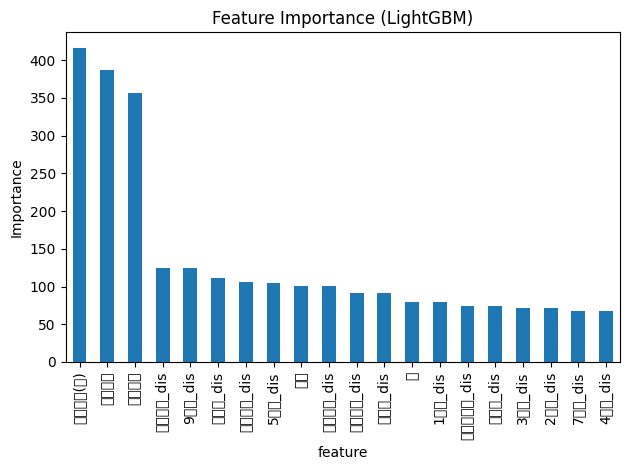

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# 특성 중요도 가져오기
importances = model.feature_importances_

# DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

# 시각화 (상위 20개)
plt.figure(figsize=(10,6))
feature_importance_df.head(20).plot(
    x='feature',
    y='importance',
    kind='bar',
    legend=False
)
plt.title("Feature Importance (LightGBM)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [76]:
X.columns

Index(['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '거래유형', '구', '동',
       '난방방식', '중앙차로_dis', '중앙차로_grade', '마을버스_dis', '마을버스_grade', '일반차로_dis',
       '일반차로_grade', '가상정류장_grade', '가로변시간_dis', '가로변시간_grade', '가로변전일_dis',
       '가로변전일_grade', '분당선_grade', '인천2호선_grade', '경의중앙선_grade', '경인선_grade',
       '6호선_grade', '과천선_grade', '경춘선_dis', '경춘선_grade', '안산선_grade',
       '경원선_grade', '1호선_dis', '1호선_grade', '장항선_grade', '7호선_dis',
       '7호선_grade', '에버라인선_grade', '신분당선(연장2)_grade', '인천1호선_grade', '2호선_dis',
       '2호선_grade', '경강선_grade', '수인선_grade', '3호선_dis', '3호선_grade',
       '우이신설선_grade', '신림선_grade', '김포골드라인_grade', '신분당선_dis', '신분당선_grade',
       '9호선(연장)_grade', '공항철도1호선_grade', '중앙선_grade', '5호선_dis', '5호선_grade',
       '일산선_grade', '신분당선(연장)_grade', '9호선_dis', '9호선_grade', '서해선_grade',
       '8호선_grade', '4호선_dis', '4호선_grade', '진접선_grade', '7호선(인천)_grade',
       '의정부선_grade', '경부선_grade', '강남역_dis', '잠실역_dis'],
      dtype='object')